## Counting Samples of wav files

In [1]:
import os
folder = 'patient-vocal-dataset'
classes = os.listdir(folder)
for cla in classes:
    samp = len([i for i in os.listdir(f'{folder}/{cla}') if i.endswith('.wav')])
    print(f'Detected {samp} samples for class: {cla}')

Detected 84 samples for class: Laryngozele
Detected 560 samples for class: Normal
Detected 392 samples for class: Vox senilis


In [ ]:
import shutil 
ffmpeg_path = shutil.which("ffmpeg")
if not ffmpeg_path:
    ffmpeg_path = r"C:\ffmpeg\bin\ffmpeg.exe"  # Fallback to known location

'C:\\ffmpeg\\bin\\ffmpeg.EXE'

## Loading Samples Into Memory

In [75]:
import os
import numpy as np
import librosa
import matplotlib.pyplot as plt
import tensorflow as tf

# Function to convert audio to spectrogram array (in memory)
def audio_to_spectrogram_array(audio_path):
    data, sr = librosa.load(audio_path, sr=None)
    spectrogram = librosa.feature.melspectrogram(y=data, sr=sr, n_mels=128)
    log_spectrogram = librosa.power_to_db(spectrogram, ref=np.max)
    
    # Convert to image format (height, width, 3) for CNN input
    plt.figure(figsize=(10, 5))
    librosa.display.specshow(log_spectrogram, sr=sr, x_axis='time', y_axis='mel')
    plt.axis('off')
    
    # Save figure to buffer instead of file
    fig = plt.gcf()
    fig.canvas.draw()
    # Convert to numpy array
    img_array = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
    img_array = img_array.reshape(fig.canvas.get_width_height()[::-1] + (3,))
    plt.close()
    
    # Resize to target dimensions
    img_array = tf.image.resize(img_array, (256, 512))
    img_array = tf.cast(img_array, tf.uint8)
    
    return img_array

# Process audio files and create in-memory dataset
print('CLASS', '\t', 'PROCESSED')
images = []
labels = []
class_names = []
class_indices = {}

for idx, class_name in enumerate(os.listdir(folder)):
    class_names.append(class_name)
    class_indices[class_name] = idx
    class_path = os.path.join(folder, class_name)
    
    processed_count = 0
    for voice in os.listdir(class_path):
        if voice.endswith('.wav'):
            voice_path = os.path.join(class_path, voice)
            img_array = audio_to_spectrogram_array(voice_path)
            
            images.append(img_array)
            labels.append(idx)
            processed_count += 1
    
    print(class_name, '\t', processed_count)

# Convert lists to numpy arrays
images = np.array(images)
labels = np.array(labels)

# Split data into training and validation sets
# Using the same seed as in the original code for consistency
np.random.seed(69)
indices = np.random.permutation(len(images))
split_index = int(len(images) * 0.8)  # 80% for training
train_indices = indices[:split_index]
val_indices = indices[split_index:]

train_images = tf.gather(images, train_indices)
train_labels = tf.gather(labels, train_indices)
val_images = tf.gather(images, val_indices)
val_labels = tf.gather(labels, val_indices)

# Create TensorFlow datasets
batch_size = 16
train_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_labels))
train_dataset = train_dataset.batch(batch_size)
val_dataset = tf.data.Dataset.from_tensor_slices((val_images, val_labels))
val_dataset = val_dataset.batch(batch_size)

# Normalize the pixel values
normalization_layer = tf.keras.layers.Rescaling(1./255)
train_dataset = train_dataset.map(lambda x, y: (normalization_layer(x), y))
val_dataset = val_dataset.map(lambda x, y: (normalization_layer(x), y))

# Check shape
for images, labels in train_dataset.take(1):
    print('Shape of train:', images.shape)
    print('Class names:', class_names)

CLASS 	 PROCESSED
Laryngozele 	 84
Vox senilis 	 392
Normal 	 560
Shape of train: (16, 256, 512, 3)
Class names: ['Laryngozele', 'Vox senilis', 'Normal']


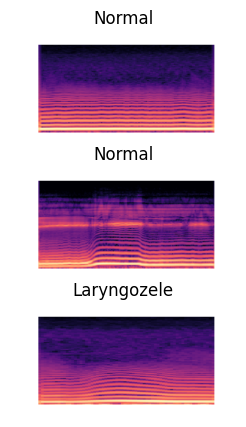

In [76]:
# Visualize some examples
plt.figure(figsize=(20, 5))
for images, labels in train_dataset.take(1):
    for i in range(3):
        ax = plt.subplot(3, 1, i+1)
        plt.imshow(images[i].numpy())
        plt.title(class_names[labels[i]])
        plt.axis("off")
image_size = (256, 512, 3)

## Defining Main CNN Model

In [77]:
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Input, Dropout, BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

es = EarlyStopping(patience=10, restore_best_weights=True, start_from_epoch=30, monitor='val_acc')
# lr = ReduceLROnPlateau(patience=4, factor=0.25)
# optA = Adam(learning_rate=0.001)
model = Sequential([
    Input(image_size),
    Conv2D(filters=32, kernel_size=3, activation='relu'),
    Dropout(0.2),
    MaxPooling2D(2, padding='same'),
    Conv2D(filters=32, kernel_size=3, activation='relu'),
    Dropout(0.3),
    MaxPooling2D(2, padding='same'),
    Conv2D(filters=32, kernel_size=3, activation='relu'),
    Dropout(0.4),
    MaxPooling2D(2, padding='same'),
    # Conv2D(filters=32, kernel_size=3, activation='relu'),
    # Dropout(0.4),
    # MaxPooling2D(2, padding='same'),

    Flatten(),
    Dense(units=64, activation='relu'),
    Dropout(0.2),
    Dense(units=3, activation='softmax'),
])
model.compile(optimizer='adam',#optA, 
              loss='sparse_categorical_crossentropy', metrics=['acc'])
model.summary()

Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_36 (Conv2D)                   │ (None, 254, 510, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_48 (Dropout)                 │ (None, 254, 510, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_36 (MaxPooling2D)      │ (None, 127, 255, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_37 (Conv2D)                   │ (None, 125, 253, 32)        │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_49 (Dropout)                 │ (None, 125, 253, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_37 (MaxPooling2D)      │ (None, 63, 127, 32)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_38 (Conv2D)                   │ (None, 61, 125, 32)         │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_50 (Dropout)                 │ (None, 61, 125, 32)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_38 (MaxPooling2D)      │ (None, 31, 63, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_12 (Flatten)                 │ (None, 62496)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_24 (Dense)                     │ (None, 64)                  │       3,999,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_51 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_25 (Dense)                     │ (None, 3)                   │             195 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,019,395 (15.33 MB)

 Trainable params: 4,019,395 (15.33 MB)

 Non-trainable params: 0 (0.00 B)

## Training and Visualizing Results

In [78]:
# Train the model
history = model.fit(
    train_dataset, 
    validation_data=val_dataset, 
    epochs=75, 
    callbacks=[es],#, lr],
    batch_size=16
)

Epoch 1/75
52/52 ━━━━━━━━━━━━━━━━━━━━ 9s 92ms/step - acc: 0.5049 - loss: 1.5735 - val_acc: 0.5529 - val_loss: 0.8201
Epoch 2/75
52/52 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - acc: 0.6807 - loss: 0.8732 - val_acc: 0.7212 - val_loss: 0.7062
Epoch 3/75
52/52 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - acc: 0.7283 - loss: 0.6948 - val_acc: 0.8173 - val_loss: 0.6990
Epoch 4/75
52/52 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - acc: 0.7696 - loss: 0.5927 - val_acc: 0.8173 - val_loss: 0.6159
Epoch 5/75
52/52 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - acc: 0.8019 - loss: 0.5156 - val_acc: 0.8173 - val_loss: 0.5818
Epoch 6/75
52/52 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - acc: 0.8176 - loss: 0.4561 - val_acc: 0.7692 - val_loss: 0.6011
Epoch 7/75
52/52 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - acc: 0.8320 - loss: 0.4414 - val_acc: 0.8221 - val_loss: 0.5045
Epoch 8/75
52/52 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - acc: 0.8443 - loss: 0.3982 - val_acc: 0.8462 - val_loss: 0.5629
Epoch 9/75
52/52 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - acc: 0.8408

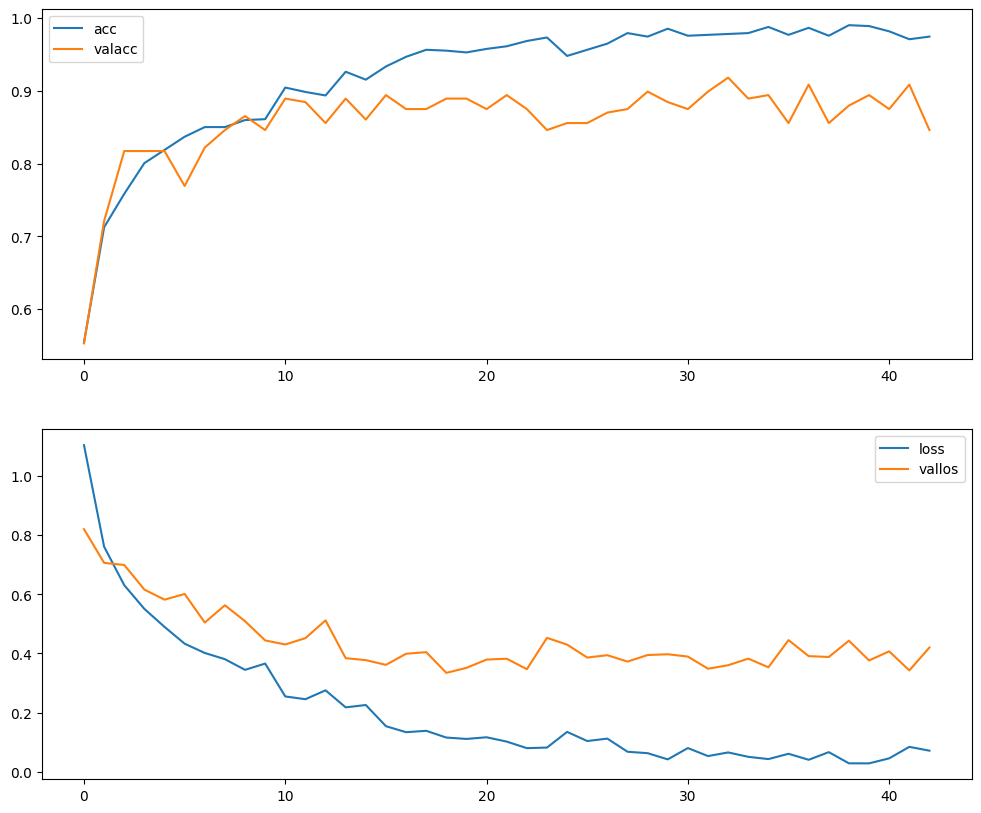

In [79]:
# Plot training history
fig, ax = plt.subplots(2, 1, figsize=(12, 10))
ax[0].plot(history.history['acc'])
ax[0].plot(history.history['val_acc'])
ax[0].legend(['acc', 'valacc'])

ax[1].plot(history.history['loss'])
ax[1].plot(history.history['val_loss'])
ax[1].legend(['loss', 'vallos'])

## Final Evaluation on Validation Set and Saving

In [80]:
# Evaluate model
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, classification_report

accuracy_scores = []
labs = []
preds = []
for images, labels in val_dataset:
    predictions = model.predict(images).argmax(axis=1)
    accuracy_scores.append(accuracy_score(labels, predictions))
    # print(precision_score(labels, predictions, average='macro', zero_division=0))
    labs += [labels]
    preds += [predictions]

xs, ys = [], []
for i in preds:
    for x in i: xs += [x]
for i in labs: 
    for x in i: ys += [int(x)]

print("VALIDATION ACCURACY:", np.mean(accuracy_scores))
print('\nClassification Report:')
print(classification_report(xs, ys, zero_division=0))
# model.save('finalcnn.keras')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
VALIDATION ACCURACY: 0.9182692307692307

Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.75      0.75        12
           1       0.91      0.89      0.90        83
           2       0.94      0.96      0.95       113

    accuracy                           0.92       208
   macro avg       0.87      0.87      0.87       208
weighted avg       0.92      0.92      0.92       208

